<a href="https://colab.research.google.com/github/667029/KVP10k/blob/main/Relation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Setup
In this section, we import necessary libraries (e.g., PyTorch, TensorFlow, and Hugging Face `datasets`) and configure any global settings.

In [ ]:
!pip install datasets torch transformers accelerate numpy tqdm tensorflow scikit-learn

In [ ]:
# Definerer drive lokasjon
drive_mount_path='/content/drive'

hidden_size = 768           # Size of the hidden vectors.
batch_size = 32             # Batch size.
test_size_percentage = 10   # Percentage of dataset to be dedicated to test
seed = 42                   # Seed for reproducibility.


# Paths to your datasets
train_dataset_path = "/content/drive/MyDrive/RE_ready/re_dataset_train_combined"
test_dataset_path = "/content/drive/MyDrive/RE_ready/re_dataset_test_combined"


## Data Loading
Load the prepared training, evaluation, and test datasets from disk using HF `load_from_disk`.

In [ ]:
import torch
from datasets import load_from_disk
import tensorflow as tf
import numpy as np


class DataUtil:
    @staticmethod
    def get_output(dataset_path=None, model_output=None, drive_mount_path=drive_mount_path, extract_hidden=False, verbose=True):
        if dataset_path is not None:
            try:
                from google.colab import drive
                drive.mount(drive_mount_path, force_remount=False)
            except Exception as e:
                if verbose:
                    print("Google Drive may already be mounted. Continuing...")
            dataset = load_from_disk(dataset_path)
            if verbose:
                print("Loaded dataset from drive.")
                print("Number of samples:", len(dataset))
                print("Column names:", dataset.column_names)
                print("First sample:", dataset[0])
            return dataset
        elif model_output is not None:
            if extract_hidden:
                if isinstance(model_output, dict) and "hidden_states" in model_output:
                    model_output = model_output["hidden_states"]
                elif isinstance(model_output, (list, tuple)):
                    model_output = model_output[-1]
            if verbose:
                print("Provided model output:")
                print(model_output)
            return model_output
        else:
            raise ValueError("Please provide either a dataset_path or a model_output.")

    @staticmethod
    def to_tf_dataset(dataset, hidden_size, batch_size=32, shuffle_buffer=1000, verbose=True):
        def generator():
            for sample in dataset:
                h_i = np.array(sample["h_i"], dtype=np.float32)
                h_j = np.array(sample["h_j"], dtype=np.float32)
                label_arr = np.array(sample["label"], dtype=np.int32)
                label = label_arr[0] if label_arr.ndim > 0 else label_arr
                key = sample["key"] if "key" in sample else "unknown"
                yield (h_i, h_j, label, key)

        first_sample = dataset[0]
        h_i_first = np.array(first_sample["h_i"], dtype=np.float32)

        if h_i_first.ndim == 1:
            output_signature = (
                tf.TensorSpec(shape=(hidden_size,), dtype=tf.float32),
                tf.TensorSpec(shape=(hidden_size,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(), dtype=tf.string),
            )
            ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
            ds = ds.shuffle(shuffle_buffer).batch(batch_size)
        elif h_i_first.ndim == 2:
            output_signature = (
                tf.TensorSpec(shape=(None, hidden_size), dtype=tf.float32),
                tf.TensorSpec(shape=(None, hidden_size), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(), dtype=tf.string),
            )
            ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
            ds = ds.shuffle(shuffle_buffer).padded_batch(
                batch_size,
                padded_shapes=([None, hidden_size], [None, hidden_size], [], [])
            )
        else:
            raise ValueError("Expected h_i to be 1D or 2D; got shape " + str(h_i_first.shape))

        if verbose:
            print(f"Converted dataset to tf.data.Dataset with batch size {batch_size}.")
        return ds

## Training Loop
Train the model: iterate over epochs and batches, compute loss, and update model weights.

In [ ]:
# Load training dataset
train_loaded_dataset = DataUtil.get_output(dataset_path=train_dataset_path)
split_dataset = train_loaded_dataset.train_test_split(test_size=test_size_percentage/100, seed=seed)

## Hent dataset fra output av layoutmvl3 modellen
# train_loaded_dataset = DataUtil.get_output(model_output=outputs, verbose=True)
# split_dataset = train_loaded_dataset.train_test_split(test_size=0.2, seed=seed)


# Explicitly naming sets
train_dataset_hf = split_dataset["train"]
eval_dataset_hf = split_dataset["test"]


# Load your separate test dataset for inference/evaluation
test_loaded_dataset = DataUtil.get_output(dataset_path=test_dataset_path)
test_dataset_hf = test_loaded_dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading dataset from disk:   0%|          | 0/35 [00:00<?, ?it/s]

Loaded dataset from drive.
Number of samples: 1411110
Column names: ['h_i', 'h_j', 'label']
First sample: {'h_i': [0.08819432556629181, 0.11771385371685028, -0.13484816253185272, -0.3929871618747711, 0.7269824743270874, 0.22924068570137024, 0.21258839964866638, 0.46119824051856995, -0.008485310710966587, -0.09344914555549622, 0.013197416439652443, -0.07395169138908386, -0.04165968298912048, -0.012204332277178764, -0.03786215931177139, -0.5777946710586548, 0.2996143400669098, -0.14252962172031403, -0.6251698136329651, 0.19645977020263672, 0.24734942615032196, -0.42366012930870056, 0.10904641449451447, -0.08125343918800354, 0.23178817331790924, -0.43984630703926086, 0.616330623626709, -0.4597790241241455, -0.234318345785141, 0.20567676424980164, -0.585768461227417, -0.10556289553642273, -0.6416462659835815, 0.026363598182797432, -0.5135732889175415, -0.11054161936044693, 0.4881322383880615, -0.242694690823555, -0.061750371009111404, -0.14020699262619019, 0.04512529447674751, -0.108396925

In [ ]:
import numpy as np
import tensorflow as tf

# Oppretter trening og test set
train_dataset = DataUtil.to_tf_dataset(train_dataset_hf, hidden_size=hidden_size, batch_size=32)
for batch in train_dataset.take(1):
    h_i_batch, h_j_batch, labels_batch, keys_batch = batch
    print("h_i batch shape:", h_i_batch.shape)
    print("h_j batch shape:", h_j_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    print("keys batch shape:", keys_batch.shape)

test_dataset = DataUtil.to_tf_dataset(test_dataset_hf, hidden_size=hidden_size, batch_size=32)
for batch in test_dataset.take(1):
    h_i_batch, h_j_batch, labels_batch, keys_batch = batch
    print("h_i batch shape:", h_i_batch.shape)
    print("h_j batch shape:", h_j_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    print("keys batch shape:", keys_batch.shape)

Converted dataset to tf.data.Dataset with batch size 32.
h_i batch shape: (32, 768)
h_j batch shape: (32, 768)
labels batch shape: (32,)
keys batch shape: (32,)
Converted dataset to tf.data.Dataset with batch size 32.
h_i batch shape: (32, 768)
h_j batch shape: (32, 768)
labels batch shape: (32,)
keys batch shape: (32,)


In [ ]:
import numpy as np
import tensorflow as tf

class Bilinear(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_relations):
        super(Bilinear, self).__init__()
        self.hidden_size = hidden_size
        self.num_relations = num_relations

    def build(self, input_shape):
        # Create weight tensor of shape (hidden_size, num_relations, hidden_size)
        self.W = self.add_weight(
            shape=(self.hidden_size, self.num_relations, self.hidden_size),
            initializer='glorot_uniform',
            trainable=True,
            name="bilinear_W"
        )
        # Bias vector of shape (num_relations,)
        self.bias = self.add_weight(
            shape=(self.num_relations,),
            initializer='zeros',
            trainable=True,
            name="bilinear_bias"
        )
        super(Bilinear, self).build(input_shape)

    def call(self, inputs):
        head, tail = inputs
        # Use einsum to compute: for each sample, head^T * W * tail.
        # Equation: 'bi,irk,bj->br' where:
        #   b: batch, i: hidden dimension from head, j: hidden dimension from tail, r: relation index.
        logits = tf.einsum('bi,irk,bj->br', head, self.W, tail)
        logits = logits + self.bias
        return logits

## Model Definition
Define the Relation Link layer/model components, including custom layers and heads.

In [ ]:
import tensorflow as tf

class RelationExtractionHead(tf.keras.Model):
    def __init__(self, hidden_size, num_relations):
        super(RelationExtractionHead, self).__init__()
        self.head_proj = tf.keras.layers.Dense(hidden_size, name="head_proj")
        self.tail_proj = tf.keras.layers.Dense(hidden_size, name="tail_proj")
        self.bilinear = Bilinear(hidden_size, num_relations)

    def call(self, inputs, training=False):
        h_i, h_j = inputs
        head = self.head_proj(h_i)
        tail = self.tail_proj(h_j)
        logits = self.bilinear((head, tail))
        return logits

## Train the model

Train the model...

In [ ]:
import numpy as np

# Hyperparameters
num_relations = 5
num_epochs = 250
learning_rate = 1e-4
num_train_samples = len(train_dataset_hf)
sample_base = int(np.ceil(num_train_samples / num_epochs))
sample_range_min = int(sample_base * 0.95)
sample_range_max = int(sample_base * 1.10)

Epoch 1/250, sampling 5481 examples...


Epoch 1: 100%|██████████| 172/172 [00:46<00:00,  3.68batch/s]


Epoch 1, Average Loss: 28.6469
Epoch 2/250, sampling 5473 examples...


Epoch 2: 100%|██████████| 172/172 [00:29<00:00,  5.86batch/s]


Epoch 2, Average Loss: 13.3306
Epoch 3/250, sampling 5289 examples...


Epoch 3: 100%|██████████| 166/166 [00:28<00:00,  5.87batch/s]


Epoch 3, Average Loss: 15.0689
Epoch 4/250, sampling 5382 examples...


Epoch 4: 100%|██████████| 169/169 [00:28<00:00,  5.89batch/s]


Epoch 4, Average Loss: 26.1958
Epoch 5/250, sampling 5119 examples...


Epoch 5: 100%|██████████| 160/160 [00:27<00:00,  5.74batch/s]


Epoch 5, Average Loss: 176.0419
Epoch 6/250, sampling 5321 examples...


Epoch 6: 100%|██████████| 167/167 [00:28<00:00,  5.84batch/s]


Epoch 6, Average Loss: 38.0800
Epoch 7/250, sampling 4974 examples...


Epoch 7: 100%|██████████| 156/156 [00:27<00:00,  5.66batch/s]


Epoch 7, Average Loss: 11.9578
Epoch 8/250, sampling 5329 examples...


Epoch 8: 100%|██████████| 167/167 [00:28<00:00,  5.85batch/s]


Epoch 8, Average Loss: 11.8075
Epoch 9/250, sampling 5358 examples...


Epoch 9: 100%|██████████| 168/168 [00:28<00:00,  5.89batch/s]


Epoch 9, Average Loss: 13.1489
Epoch 10/250, sampling 5055 examples...


Epoch 10: 100%|██████████| 158/158 [00:27<00:00,  5.68batch/s]


Epoch 10, Average Loss: 5.2385
Epoch 11/250, sampling 4935 examples...


Epoch 11: 100%|██████████| 155/155 [00:27<00:00,  5.66batch/s]


Epoch 11, Average Loss: 13.0203
Epoch 12/250, sampling 5582 examples...


Epoch 12: 100%|██████████| 175/175 [00:29<00:00,  5.95batch/s]


Epoch 12, Average Loss: 7.5847
Epoch 13/250, sampling 5506 examples...


Epoch 13: 100%|██████████| 173/173 [00:28<00:00,  5.98batch/s]


Epoch 13, Average Loss: 4.8325
Epoch 14/250, sampling 5408 examples...


Epoch 14: 100%|██████████| 169/169 [00:28<00:00,  5.93batch/s]


Epoch 14, Average Loss: 15.7481
Epoch 15/250, sampling 5385 examples...


Epoch 15: 100%|██████████| 169/169 [00:28<00:00,  5.86batch/s]


Epoch 15, Average Loss: 28.1008
Epoch 16/250, sampling 5392 examples...


Epoch 16: 100%|██████████| 169/169 [00:28<00:00,  5.91batch/s]


Epoch 16, Average Loss: 26.6352
Epoch 17/250, sampling 5558 examples...


Epoch 17: 100%|██████████| 174/174 [00:29<00:00,  5.91batch/s]


Epoch 17, Average Loss: 85.5581
Epoch 18/250, sampling 5020 examples...


Epoch 18: 100%|██████████| 157/157 [00:27<00:00,  5.69batch/s]


Epoch 18, Average Loss: 34.0248
Epoch 19/250, sampling 5491 examples...


Epoch 19: 100%|██████████| 172/172 [00:29<00:00,  5.91batch/s]


Epoch 19, Average Loss: 82.9623
Epoch 20/250, sampling 5484 examples...


Epoch 20: 100%|██████████| 172/172 [00:28<00:00,  5.93batch/s]


Epoch 20, Average Loss: 9.8572
Epoch 21/250, sampling 5126 examples...


Epoch 21: 100%|██████████| 161/161 [00:27<00:00,  5.85batch/s]


Epoch 21, Average Loss: 15.4952
Epoch 22/250, sampling 5166 examples...


Epoch 22: 100%|██████████| 162/162 [00:28<00:00,  5.75batch/s]


Epoch 22, Average Loss: 47.2119
Epoch 23/250, sampling 5388 examples...


Epoch 23: 100%|██████████| 169/169 [00:30<00:00,  5.58batch/s]


Epoch 23, Average Loss: 23.0172
Epoch 24/250, sampling 4975 examples...


Epoch 24: 100%|██████████| 156/156 [00:28<00:00,  5.46batch/s]


Epoch 24, Average Loss: 30.7441
Epoch 25/250, sampling 4943 examples...


Epoch 25: 100%|██████████| 155/155 [00:27<00:00,  5.58batch/s]


Epoch 25, Average Loss: 66.3634
Epoch 26/250, sampling 5588 examples...


Epoch 26: 100%|██████████| 175/175 [00:29<00:00,  5.94batch/s]


Epoch 26, Average Loss: 63.0502
Epoch 27/250, sampling 5081 examples...


Epoch 27: 100%|██████████| 159/159 [00:27<00:00,  5.70batch/s]


Epoch 27, Average Loss: 16.1827
Epoch 28/250, sampling 5355 examples...


Epoch 28: 100%|██████████| 168/168 [00:29<00:00,  5.73batch/s]


Epoch 28, Average Loss: 16.3949
Epoch 29/250, sampling 5351 examples...


Epoch 29: 100%|██████████| 168/168 [00:28<00:00,  5.87batch/s]


Epoch 29, Average Loss: 16.5654
Epoch 30/250, sampling 4919 examples...


Epoch 30: 100%|██████████| 154/154 [00:27<00:00,  5.61batch/s]


Epoch 30, Average Loss: 198.9076
Epoch 31/250, sampling 4986 examples...


Epoch 31: 100%|██████████| 156/156 [00:27<00:00,  5.64batch/s]


Epoch 31, Average Loss: 42.5058
Epoch 32/250, sampling 5329 examples...


Epoch 32: 100%|██████████| 167/167 [00:28<00:00,  5.83batch/s]


Epoch 32, Average Loss: 18.0566
Epoch 33/250, sampling 4908 examples...


Epoch 33: 100%|██████████| 154/154 [00:27<00:00,  5.63batch/s]


Epoch 33, Average Loss: 34.7474
Epoch 34/250, sampling 5406 examples...


Epoch 34: 100%|██████████| 169/169 [00:28<00:00,  5.84batch/s]


Epoch 34, Average Loss: 10.2834
Epoch 35/250, sampling 5044 examples...


Epoch 35: 100%|██████████| 158/158 [00:28<00:00,  5.62batch/s]


Epoch 35, Average Loss: 18.6516
Epoch 36/250, sampling 5183 examples...


Epoch 36: 100%|██████████| 162/162 [00:28<00:00,  5.72batch/s]


Epoch 36, Average Loss: 24.5001
Epoch 37/250, sampling 5199 examples...


Epoch 37: 100%|██████████| 163/163 [00:28<00:00,  5.79batch/s]


Epoch 37, Average Loss: 18.9917
Epoch 38/250, sampling 5394 examples...


Epoch 38: 100%|██████████| 169/169 [00:29<00:00,  5.82batch/s]


Epoch 38, Average Loss: 7.4621
Epoch 39/250, sampling 5417 examples...


Epoch 39: 100%|██████████| 170/170 [00:28<00:00,  5.89batch/s]


Epoch 39, Average Loss: 80.6523
Epoch 40/250, sampling 5035 examples...


Epoch 40: 100%|██████████| 158/158 [00:27<00:00,  5.67batch/s]


Epoch 40, Average Loss: 32.1613
Epoch 41/250, sampling 4968 examples...


Epoch 41: 100%|██████████| 156/156 [00:27<00:00,  5.67batch/s]


Epoch 41, Average Loss: 12.0225
Epoch 42/250, sampling 5243 examples...


Epoch 42: 100%|██████████| 164/164 [00:28<00:00,  5.81batch/s]


Epoch 42, Average Loss: 7.1769
Epoch 43/250, sampling 5441 examples...


Epoch 43: 100%|██████████| 171/171 [00:28<00:00,  5.91batch/s]


Epoch 43, Average Loss: 95.4128
Epoch 44/250, sampling 5119 examples...


Epoch 44: 100%|██████████| 160/160 [00:27<00:00,  5.75batch/s]


Epoch 44, Average Loss: 213.6605
Epoch 45/250, sampling 5074 examples...


Epoch 45: 100%|██████████| 159/159 [00:27<00:00,  5.71batch/s]


Epoch 45, Average Loss: 6.4350
Epoch 46/250, sampling 5249 examples...


Epoch 46: 100%|██████████| 165/165 [00:28<00:00,  5.79batch/s]


Epoch 46, Average Loss: 9.4431
Epoch 47/250, sampling 4888 examples...


Epoch 47: 100%|██████████| 153/153 [00:27<00:00,  5.53batch/s]


Epoch 47, Average Loss: 8.1903
Epoch 48/250, sampling 4935 examples...


Epoch 48: 100%|██████████| 155/155 [00:27<00:00,  5.59batch/s]


Epoch 48, Average Loss: 3.4004
Epoch 49/250, sampling 5530 examples...


Epoch 49: 100%|██████████| 173/173 [00:29<00:00,  5.91batch/s]


Epoch 49, Average Loss: 2.4669
Epoch 50/250, sampling 5555 examples...


Epoch 50: 100%|██████████| 174/174 [00:29<00:00,  5.90batch/s]


Epoch 50, Average Loss: 8.4198
Epoch 51/250, sampling 5550 examples...


Epoch 51: 100%|██████████| 174/174 [00:29<00:00,  5.98batch/s]


Epoch 51, Average Loss: 15.5423
Epoch 52/250, sampling 4973 examples...


Epoch 52: 100%|██████████| 156/156 [00:27<00:00,  5.63batch/s]


Epoch 52, Average Loss: 6.5874
Epoch 53/250, sampling 5281 examples...


Epoch 53: 100%|██████████| 166/166 [00:28<00:00,  5.80batch/s]


Epoch 53, Average Loss: 29.1844
Epoch 54/250, sampling 5031 examples...


Epoch 54: 100%|██████████| 158/158 [00:27<00:00,  5.68batch/s]


Epoch 54, Average Loss: 5.1748
Epoch 55/250, sampling 5060 examples...


Epoch 55: 100%|██████████| 159/159 [00:28<00:00,  5.65batch/s]


Epoch 55, Average Loss: 6.2629
Epoch 56/250, sampling 5179 examples...


Epoch 56: 100%|██████████| 162/162 [00:28<00:00,  5.65batch/s]


Epoch 56, Average Loss: 19.9987
Epoch 57/250, sampling 5045 examples...


Epoch 57: 100%|██████████| 158/158 [00:28<00:00,  5.60batch/s]


Epoch 57, Average Loss: 19.8215
Epoch 58/250, sampling 5515 examples...


Epoch 58: 100%|██████████| 173/173 [00:29<00:00,  5.90batch/s]


Epoch 58, Average Loss: 27.6929
Epoch 59/250, sampling 5239 examples...


Epoch 59: 100%|██████████| 164/164 [00:28<00:00,  5.77batch/s]


Epoch 59, Average Loss: 202.0656
Epoch 60/250, sampling 4867 examples...


Epoch 60: 100%|██████████| 153/153 [00:27<00:00,  5.53batch/s]


Epoch 60, Average Loss: 210.0960
Epoch 61/250, sampling 5585 examples...


Epoch 61: 100%|██████████| 175/175 [00:29<00:00,  5.93batch/s]


Epoch 61, Average Loss: 86.0476
Epoch 62/250, sampling 5362 examples...


Epoch 62: 100%|██████████| 168/168 [00:28<00:00,  5.81batch/s]


Epoch 62, Average Loss: 23.1266
Epoch 63/250, sampling 5549 examples...


Epoch 63: 100%|██████████| 174/174 [00:29<00:00,  5.90batch/s]


Epoch 63, Average Loss: 18.1686
Epoch 64/250, sampling 5107 examples...


Epoch 64: 100%|██████████| 160/160 [00:28<00:00,  5.65batch/s]


Epoch 64, Average Loss: 10.5895
Epoch 65/250, sampling 5127 examples...


Epoch 65: 100%|██████████| 161/161 [00:28<00:00,  5.73batch/s]


Epoch 65, Average Loss: 3.3468
Epoch 66/250, sampling 4946 examples...


Epoch 66: 100%|██████████| 155/155 [00:27<00:00,  5.57batch/s]


Epoch 66, Average Loss: 3.3121
Epoch 67/250, sampling 5349 examples...


Epoch 67: 100%|██████████| 168/168 [00:28<00:00,  5.89batch/s]


Epoch 67, Average Loss: 5.0164
Epoch 68/250, sampling 4996 examples...


Epoch 68: 100%|██████████| 157/157 [00:27<00:00,  5.67batch/s]


Epoch 68, Average Loss: 35.6012
Epoch 69/250, sampling 4993 examples...


Epoch 69: 100%|██████████| 157/157 [00:27<00:00,  5.73batch/s]


Epoch 69, Average Loss: 4.2141
Epoch 70/250, sampling 5301 examples...


Epoch 70: 100%|██████████| 166/166 [00:28<00:00,  5.79batch/s]


Epoch 70, Average Loss: 8.2424
Epoch 71/250, sampling 5088 examples...


Epoch 71: 100%|██████████| 159/159 [00:27<00:00,  5.71batch/s]


Epoch 71, Average Loss: 25.7258
Epoch 72/250, sampling 5577 examples...


Epoch 72: 100%|██████████| 175/175 [00:29<00:00,  5.99batch/s]


Epoch 72, Average Loss: 121.9044
Epoch 73/250, sampling 5181 examples...


Epoch 73: 100%|██████████| 162/162 [00:28<00:00,  5.71batch/s]


Epoch 73, Average Loss: 66.9051
Epoch 74/250, sampling 5432 examples...


Epoch 74: 100%|██████████| 170/170 [00:28<00:00,  5.89batch/s]


Epoch 74, Average Loss: 34.4602
Epoch 75/250, sampling 5204 examples...


Epoch 75: 100%|██████████| 163/163 [00:28<00:00,  5.70batch/s]


Epoch 75, Average Loss: 11.6123
Epoch 76/250, sampling 5181 examples...


Epoch 76: 100%|██████████| 162/162 [00:28<00:00,  5.76batch/s]


Epoch 76, Average Loss: 14.8522
Epoch 77/250, sampling 5049 examples...


Epoch 77: 100%|██████████| 158/158 [00:28<00:00,  5.60batch/s]


Epoch 77, Average Loss: 10.1893
Epoch 78/250, sampling 5352 examples...


Epoch 78: 100%|██████████| 168/168 [00:28<00:00,  5.82batch/s]


Epoch 78, Average Loss: 17.3897
Epoch 79/250, sampling 5132 examples...


Epoch 79: 100%|██████████| 161/161 [00:28<00:00,  5.72batch/s]


Epoch 79, Average Loss: 16.0030
Epoch 80/250, sampling 4844 examples...


Epoch 80: 100%|██████████| 152/152 [00:27<00:00,  5.51batch/s]


Epoch 80, Average Loss: 4.3550
Epoch 81/250, sampling 4872 examples...


Epoch 81: 100%|██████████| 153/153 [00:27<00:00,  5.60batch/s]


Epoch 81, Average Loss: 20.7565
Epoch 82/250, sampling 5004 examples...


Epoch 82: 100%|██████████| 157/157 [00:27<00:00,  5.68batch/s]


Epoch 82, Average Loss: 211.7130
Epoch 83/250, sampling 5063 examples...


Epoch 83: 100%|██████████| 159/159 [00:28<00:00,  5.67batch/s]


Epoch 83, Average Loss: 47.2577
Epoch 84/250, sampling 4861 examples...


Epoch 84: 100%|██████████| 152/152 [00:27<00:00,  5.50batch/s]


Epoch 84, Average Loss: 19.2977
Epoch 85/250, sampling 4850 examples...


Epoch 85: 100%|██████████| 152/152 [00:27<00:00,  5.52batch/s]


Epoch 85, Average Loss: 24.6877
Epoch 86/250, sampling 4982 examples...


Epoch 86: 100%|██████████| 156/156 [00:27<00:00,  5.63batch/s]


Epoch 86, Average Loss: 21.7326
Epoch 87/250, sampling 5178 examples...


Epoch 87: 100%|██████████| 162/162 [00:28<00:00,  5.70batch/s]


Epoch 87, Average Loss: 18.0695
Epoch 88/250, sampling 5133 examples...


Epoch 88: 100%|██████████| 161/161 [00:28<00:00,  5.72batch/s]


Epoch 88, Average Loss: 9.7622
Epoch 89/250, sampling 5580 examples...


Epoch 89: 100%|██████████| 175/175 [00:29<00:00,  5.90batch/s]


Epoch 89, Average Loss: 11.1595
Epoch 90/250, sampling 5030 examples...


Epoch 90: 100%|██████████| 158/158 [00:28<00:00,  5.59batch/s]


Epoch 90, Average Loss: 16.1362
Epoch 91/250, sampling 5107 examples...


Epoch 91: 100%|██████████| 160/160 [00:28<00:00,  5.68batch/s]


Epoch 91, Average Loss: 10.4098
Epoch 92/250, sampling 5423 examples...


Epoch 92: 100%|██████████| 170/170 [00:29<00:00,  5.85batch/s]


Epoch 92, Average Loss: 59.7924
Epoch 93/250, sampling 4834 examples...


Epoch 93: 100%|██████████| 152/152 [00:27<00:00,  5.54batch/s]


Epoch 93, Average Loss: 29.6727
Epoch 94/250, sampling 5140 examples...


Epoch 94: 100%|██████████| 161/161 [00:28<00:00,  5.70batch/s]


Epoch 94, Average Loss: 448.3622
Epoch 95/250, sampling 5323 examples...


Epoch 95: 100%|██████████| 167/167 [00:28<00:00,  5.86batch/s]


Epoch 95, Average Loss: 40.4161
Epoch 96/250, sampling 5382 examples...


Epoch 96: 100%|██████████| 169/169 [00:28<00:00,  5.88batch/s]


Epoch 96, Average Loss: 36.5664
Epoch 97/250, sampling 5068 examples...


Epoch 97: 100%|██████████| 159/159 [00:27<00:00,  5.70batch/s]


Epoch 97, Average Loss: 7.3329
Epoch 98/250, sampling 4927 examples...


Epoch 98: 100%|██████████| 154/154 [00:27<00:00,  5.54batch/s]


Epoch 98, Average Loss: 12.4332
Epoch 99/250, sampling 5304 examples...


Epoch 99: 100%|██████████| 166/166 [00:28<00:00,  5.74batch/s]


Epoch 99, Average Loss: 16.2035
Epoch 100/250, sampling 5398 examples...


Epoch 100: 100%|██████████| 169/169 [00:28<00:00,  5.83batch/s]


Epoch 100, Average Loss: 10.7649
Epoch 101/250, sampling 5186 examples...


Epoch 101: 100%|██████████| 163/163 [00:28<00:00,  5.72batch/s]


Epoch 101, Average Loss: 21.3838
Epoch 102/250, sampling 5380 examples...


Epoch 102: 100%|██████████| 169/169 [00:28<00:00,  5.88batch/s]


Epoch 102, Average Loss: 25.6385
Epoch 103/250, sampling 4976 examples...


Epoch 103: 100%|██████████| 156/156 [00:27<00:00,  5.62batch/s]


Epoch 103, Average Loss: 9.0869
Epoch 104/250, sampling 5453 examples...


Epoch 104: 100%|██████████| 171/171 [00:29<00:00,  5.88batch/s]


Epoch 104, Average Loss: 9.7275
Epoch 105/250, sampling 4987 examples...


Epoch 105: 100%|██████████| 156/156 [00:27<00:00,  5.62batch/s]


Epoch 105, Average Loss: 22.7177
Epoch 106/250, sampling 5557 examples...


Epoch 106: 100%|██████████| 174/174 [00:29<00:00,  5.92batch/s]


Epoch 106, Average Loss: 28.4623
Epoch 107/250, sampling 5210 examples...


Epoch 107: 100%|██████████| 163/163 [00:28<00:00,  5.68batch/s]


Epoch 107, Average Loss: 2.2356
Epoch 108/250, sampling 5523 examples...


Epoch 108: 100%|██████████| 173/173 [00:29<00:00,  5.89batch/s]


Epoch 108, Average Loss: 38.6096
Epoch 109/250, sampling 5360 examples...


Epoch 109: 100%|██████████| 168/168 [00:28<00:00,  5.81batch/s]


Epoch 109, Average Loss: 23.0554
Epoch 110/250, sampling 5181 examples...


Epoch 110: 100%|██████████| 162/162 [00:28<00:00,  5.66batch/s]


Epoch 110, Average Loss: 59.8077
Epoch 111/250, sampling 5166 examples...


Epoch 111: 100%|██████████| 162/162 [00:28<00:00,  5.77batch/s]


Epoch 111, Average Loss: 30.6600
Epoch 112/250, sampling 5184 examples...


Epoch 112: 100%|██████████| 162/162 [00:28<00:00,  5.72batch/s]


Epoch 112, Average Loss: 14.3243
Epoch 113/250, sampling 5554 examples...


Epoch 113: 100%|██████████| 174/174 [00:28<00:00,  6.05batch/s]


Epoch 113, Average Loss: 69.6890
Epoch 114/250, sampling 5374 examples...


Epoch 114: 100%|██████████| 168/168 [00:28<00:00,  5.83batch/s]


Epoch 114, Average Loss: 135.2967
Epoch 115/250, sampling 5570 examples...


Epoch 115: 100%|██████████| 175/175 [00:29<00:00,  5.97batch/s]


Epoch 115, Average Loss: 165.9477
Epoch 116/250, sampling 5582 examples...


Epoch 116: 100%|██████████| 175/175 [00:29<00:00,  5.96batch/s]


Epoch 116, Average Loss: 30.6974
Epoch 117/250, sampling 5550 examples...


Epoch 117: 100%|██████████| 174/174 [00:28<00:00,  6.05batch/s]


Epoch 117, Average Loss: 12.2167
Epoch 118/250, sampling 5066 examples...


Epoch 118: 100%|██████████| 159/159 [00:28<00:00,  5.67batch/s]


Epoch 118, Average Loss: 8.1466
Epoch 119/250, sampling 5207 examples...


Epoch 119: 100%|██████████| 163/163 [00:28<00:00,  5.65batch/s]


Epoch 119, Average Loss: 125.1540
Epoch 120/250, sampling 4909 examples...


Epoch 120: 100%|██████████| 154/154 [00:28<00:00,  5.50batch/s]


Epoch 120, Average Loss: 14.9689
Epoch 121/250, sampling 5458 examples...


Epoch 121: 100%|██████████| 171/171 [00:29<00:00,  5.83batch/s]


Epoch 121, Average Loss: 21.9066
Epoch 122/250, sampling 5579 examples...


Epoch 122: 100%|██████████| 175/175 [00:29<00:00,  5.98batch/s]


Epoch 122, Average Loss: 25.3172
Epoch 123/250, sampling 5560 examples...


Epoch 123: 100%|██████████| 174/174 [00:29<00:00,  5.91batch/s]


Epoch 123, Average Loss: 10.1525
Epoch 124/250, sampling 5163 examples...


Epoch 124: 100%|██████████| 162/162 [00:28<00:00,  5.73batch/s]


Epoch 124, Average Loss: 9.9676
Epoch 125/250, sampling 5488 examples...


Epoch 125: 100%|██████████| 172/172 [00:29<00:00,  5.89batch/s]


Epoch 125, Average Loss: 12.5924
Epoch 126/250, sampling 4856 examples...


Epoch 126: 100%|██████████| 152/152 [00:27<00:00,  5.49batch/s]


Epoch 126, Average Loss: 14.3842
Epoch 127/250, sampling 5570 examples...


Epoch 127: 100%|██████████| 175/175 [00:29<00:00,  5.95batch/s]


Epoch 127, Average Loss: 2.9160
Epoch 128/250, sampling 5000 examples...


Epoch 128: 100%|██████████| 157/157 [00:28<00:00,  5.60batch/s]


Epoch 128, Average Loss: 45.0173
Epoch 129/250, sampling 4956 examples...


Epoch 129: 100%|██████████| 155/155 [00:27<00:00,  5.59batch/s]


Epoch 129, Average Loss: 4.6356
Epoch 130/250, sampling 4932 examples...


Epoch 130: 100%|██████████| 155/155 [00:27<00:00,  5.55batch/s]


Epoch 130, Average Loss: 16.2623
Epoch 131/250, sampling 4956 examples...


Epoch 131: 100%|██████████| 155/155 [00:27<00:00,  5.60batch/s]


Epoch 131, Average Loss: 22.4413
Epoch 132/250, sampling 5572 examples...


Epoch 132: 100%|██████████| 175/175 [00:29<00:00,  5.93batch/s]


Epoch 132, Average Loss: 20.9201
Epoch 133/250, sampling 4995 examples...


Epoch 133: 100%|██████████| 157/157 [00:27<00:00,  5.64batch/s]


Epoch 133, Average Loss: 94.5718
Epoch 134/250, sampling 5373 examples...


Epoch 134: 100%|██████████| 168/168 [00:28<00:00,  5.98batch/s]


Epoch 134, Average Loss: 44.1554
Epoch 135/250, sampling 5568 examples...


Epoch 135: 100%|██████████| 174/174 [00:29<00:00,  5.87batch/s]


Epoch 135, Average Loss: 210.0389
Epoch 136/250, sampling 5251 examples...


Epoch 136: 100%|██████████| 165/165 [00:28<00:00,  5.71batch/s]


Epoch 136, Average Loss: 30.5314
Epoch 137/250, sampling 5365 examples...


Epoch 137: 100%|██████████| 168/168 [00:29<00:00,  5.75batch/s]


Epoch 137, Average Loss: 39.9360
Epoch 138/250, sampling 4913 examples...


Epoch 138: 100%|██████████| 154/154 [00:27<00:00,  5.56batch/s]


Epoch 138, Average Loss: 82.2231
Epoch 139/250, sampling 5194 examples...


Epoch 139: 100%|██████████| 163/163 [00:28<00:00,  5.76batch/s]


Epoch 139, Average Loss: 10.3633
Epoch 140/250, sampling 5487 examples...


Epoch 140: 100%|██████████| 172/172 [00:29<00:00,  5.92batch/s]


Epoch 140, Average Loss: 3.6390
Epoch 141/250, sampling 5452 examples...


Epoch 141: 100%|██████████| 171/171 [00:28<00:00,  5.92batch/s]


Epoch 141, Average Loss: 3.1203
Epoch 142/250, sampling 5350 examples...


Epoch 142: 100%|██████████| 168/168 [00:28<00:00,  5.87batch/s]


Epoch 142, Average Loss: 9.6917
Epoch 143/250, sampling 4946 examples...


Epoch 143: 100%|██████████| 155/155 [00:27<00:00,  5.59batch/s]


Epoch 143, Average Loss: 42.7465
Epoch 144/250, sampling 5493 examples...


Epoch 144: 100%|██████████| 172/172 [00:29<00:00,  5.87batch/s]


Epoch 144, Average Loss: 31.3999
Epoch 145/250, sampling 5122 examples...


Epoch 145: 100%|██████████| 161/161 [00:28<00:00,  5.66batch/s]


Epoch 145, Average Loss: 5.6215
Epoch 146/250, sampling 5341 examples...


Epoch 146: 100%|██████████| 167/167 [00:28<00:00,  5.80batch/s]


Epoch 146, Average Loss: 2.0078
Epoch 147/250, sampling 5248 examples...


Epoch 147: 100%|██████████| 164/164 [00:28<00:00,  5.69batch/s]


Epoch 147, Average Loss: 4.1942
Epoch 148/250, sampling 4980 examples...


Epoch 148: 100%|██████████| 156/156 [00:28<00:00,  5.55batch/s]


Epoch 148, Average Loss: 13.5891
Epoch 149/250, sampling 5145 examples...


Epoch 149: 100%|██████████| 161/161 [00:28<00:00,  5.66batch/s]


Epoch 149, Average Loss: 47.9202
Epoch 150/250, sampling 5151 examples...


Epoch 150: 100%|██████████| 161/161 [00:28<00:00,  5.69batch/s]


Epoch 150, Average Loss: 14.3949
Epoch 151/250, sampling 5454 examples...


Epoch 151: 100%|██████████| 171/171 [00:29<00:00,  5.83batch/s]


Epoch 151, Average Loss: 11.0646
Epoch 152/250, sampling 5170 examples...


Epoch 152: 100%|██████████| 162/162 [00:28<00:00,  5.63batch/s]


Epoch 152, Average Loss: 4.6511
Epoch 153/250, sampling 5009 examples...


Epoch 153: 100%|██████████| 157/157 [00:27<00:00,  5.71batch/s]


Epoch 153, Average Loss: 3.2023
Epoch 154/250, sampling 5067 examples...


Epoch 154: 100%|██████████| 159/159 [00:28<00:00,  5.67batch/s]


Epoch 154, Average Loss: 2.8184
Epoch 155/250, sampling 5049 examples...


Epoch 155: 100%|██████████| 158/158 [00:28<00:00,  5.58batch/s]


Epoch 155, Average Loss: 4.9684
Epoch 156/250, sampling 5442 examples...


Epoch 156: 100%|██████████| 171/171 [00:29<00:00,  5.85batch/s]


Epoch 156, Average Loss: 145.3127
Epoch 157/250, sampling 5539 examples...


Epoch 157: 100%|██████████| 174/174 [00:29<00:00,  5.91batch/s]


Epoch 157, Average Loss: 401.7436
Epoch 158/250, sampling 5394 examples...


Epoch 158: 100%|██████████| 169/169 [00:29<00:00,  5.81batch/s]


Epoch 158, Average Loss: 20.0895
Epoch 159/250, sampling 5245 examples...


Epoch 159: 100%|██████████| 164/164 [00:29<00:00,  5.61batch/s]


Epoch 159, Average Loss: 27.7282
Epoch 160/250, sampling 5203 examples...


Epoch 160: 100%|██████████| 163/163 [00:28<00:00,  5.81batch/s]


Epoch 160, Average Loss: 4.4786
Epoch 161/250, sampling 5440 examples...


Epoch 161: 100%|██████████| 170/170 [00:29<00:00,  5.81batch/s]


Epoch 161, Average Loss: 4.4133
Epoch 162/250, sampling 5108 examples...


Epoch 162: 100%|██████████| 160/160 [00:28<00:00,  5.69batch/s]


Epoch 162, Average Loss: 5.4467
Epoch 163/250, sampling 4932 examples...


Epoch 163: 100%|██████████| 155/155 [00:28<00:00,  5.50batch/s]


Epoch 163, Average Loss: 11.3992
Epoch 164/250, sampling 5567 examples...


Epoch 164: 100%|██████████| 174/174 [00:29<00:00,  5.89batch/s]


Epoch 164, Average Loss: 3.4337
Epoch 165/250, sampling 5482 examples...


Epoch 165: 100%|██████████| 172/172 [00:29<00:00,  5.89batch/s]


Epoch 165, Average Loss: 6.3418
Epoch 166/250, sampling 5274 examples...


Epoch 166: 100%|██████████| 165/165 [00:28<00:00,  5.82batch/s]


Epoch 166, Average Loss: 2.9603
Epoch 167/250, sampling 5277 examples...


Epoch 167: 100%|██████████| 165/165 [00:28<00:00,  5.76batch/s]


Epoch 167, Average Loss: 5.4805
Epoch 168/250, sampling 5310 examples...


Epoch 168: 100%|██████████| 166/166 [00:28<00:00,  5.78batch/s]


Epoch 168, Average Loss: 9.3951
Epoch 169/250, sampling 5318 examples...


Epoch 169: 100%|██████████| 167/167 [00:28<00:00,  5.82batch/s]


Epoch 169, Average Loss: 88.1083
Epoch 170/250, sampling 5310 examples...


Epoch 170: 100%|██████████| 166/166 [00:28<00:00,  5.76batch/s]


Epoch 170, Average Loss: 18.9311
Epoch 171/250, sampling 5029 examples...


Epoch 171: 100%|██████████| 158/158 [00:27<00:00,  5.65batch/s]


Epoch 171, Average Loss: 2.1485
Epoch 172/250, sampling 5202 examples...


Epoch 172: 100%|██████████| 163/163 [00:28<00:00,  5.66batch/s]


Epoch 172, Average Loss: 87.3720
Epoch 173/250, sampling 4999 examples...


Epoch 173: 100%|██████████| 157/157 [00:28<00:00,  5.57batch/s]


Epoch 173, Average Loss: 68.0424
Epoch 174/250, sampling 5526 examples...


Epoch 174: 100%|██████████| 173/173 [00:28<00:00,  5.97batch/s]


Epoch 174, Average Loss: 19.6799
Epoch 175/250, sampling 4967 examples...


Epoch 175: 100%|██████████| 156/156 [00:27<00:00,  5.61batch/s]


Epoch 175, Average Loss: 18.1863
Epoch 176/250, sampling 5003 examples...


Epoch 176: 100%|██████████| 157/157 [00:27<00:00,  5.64batch/s]


Epoch 176, Average Loss: 16.3998
Epoch 177/250, sampling 5521 examples...


Epoch 177: 100%|██████████| 173/173 [00:29<00:00,  5.88batch/s]


Epoch 177, Average Loss: 21.5408
Epoch 178/250, sampling 5177 examples...


Epoch 178: 100%|██████████| 162/162 [00:28<00:00,  5.69batch/s]


Epoch 178, Average Loss: 4.9628
Epoch 179/250, sampling 5013 examples...


Epoch 179: 100%|██████████| 157/157 [00:27<00:00,  5.63batch/s]


Epoch 179, Average Loss: 69.8796
Epoch 180/250, sampling 5230 examples...


Epoch 180: 100%|██████████| 164/164 [00:28<00:00,  5.71batch/s]


Epoch 180, Average Loss: 21.8030
Epoch 181/250, sampling 5536 examples...


Epoch 181: 100%|██████████| 173/173 [00:29<00:00,  5.86batch/s]


Epoch 181, Average Loss: 73.4425
Epoch 182/250, sampling 5308 examples...


Epoch 182: 100%|██████████| 166/166 [00:28<00:00,  5.80batch/s]


Epoch 182, Average Loss: 40.0575
Epoch 183/250, sampling 4871 examples...


Epoch 183: 100%|██████████| 153/153 [00:27<00:00,  5.53batch/s]


Epoch 183, Average Loss: 42.9363
Epoch 184/250, sampling 5195 examples...


Epoch 184: 100%|██████████| 163/163 [00:28<00:00,  5.66batch/s]


Epoch 184, Average Loss: 28.4975
Epoch 185/250, sampling 5469 examples...


Epoch 185: 100%|██████████| 171/171 [00:29<00:00,  5.83batch/s]


Epoch 185, Average Loss: 25.0848
Epoch 186/250, sampling 4889 examples...


Epoch 186: 100%|██████████| 153/153 [00:27<00:00,  5.49batch/s]


Epoch 186, Average Loss: 5.1667
Epoch 187/250, sampling 4985 examples...


Epoch 187: 100%|██████████| 156/156 [00:28<00:00,  5.51batch/s]


Epoch 187, Average Loss: 19.9825
Epoch 188/250, sampling 4891 examples...


Epoch 188: 100%|██████████| 153/153 [00:28<00:00,  5.44batch/s]


Epoch 188, Average Loss: 4.8768
Epoch 189/250, sampling 5073 examples...


Epoch 189: 100%|██████████| 159/159 [00:28<00:00,  5.59batch/s]


Epoch 189, Average Loss: 2.7985
Epoch 190/250, sampling 5092 examples...


Epoch 190: 100%|██████████| 160/160 [00:28<00:00,  5.60batch/s]


Epoch 190, Average Loss: 10.9583
Epoch 191/250, sampling 4883 examples...


Epoch 191: 100%|██████████| 153/153 [00:27<00:00,  5.49batch/s]


Epoch 191, Average Loss: 7.4830
Epoch 192/250, sampling 4980 examples...


Epoch 192: 100%|██████████| 156/156 [00:28<00:00,  5.53batch/s]


Epoch 192, Average Loss: 15.5603
Epoch 193/250, sampling 5259 examples...


Epoch 193: 100%|██████████| 165/165 [00:28<00:00,  5.70batch/s]


Epoch 193, Average Loss: 262.2825
Epoch 194/250, sampling 5520 examples...


Epoch 194: 100%|██████████| 173/173 [00:29<00:00,  5.84batch/s]


Epoch 194, Average Loss: 82.2408
Epoch 195/250, sampling 5556 examples...


Epoch 195: 100%|██████████| 174/174 [00:29<00:00,  5.86batch/s]


Epoch 195, Average Loss: 254.8500
Epoch 196/250, sampling 5164 examples...


Epoch 196: 100%|██████████| 162/162 [00:28<00:00,  5.66batch/s]


Epoch 196, Average Loss: 51.9382
Epoch 197/250, sampling 4861 examples...


Epoch 197: 100%|██████████| 152/152 [00:27<00:00,  5.46batch/s]


Epoch 197, Average Loss: 25.3841
Epoch 198/250, sampling 5036 examples...


Epoch 198: 100%|██████████| 158/158 [00:28<00:00,  5.59batch/s]


Epoch 198, Average Loss: 11.2606
Epoch 199/250, sampling 5208 examples...


Epoch 199: 100%|██████████| 163/163 [00:28<00:00,  5.68batch/s]


Epoch 199, Average Loss: 11.5681
Epoch 200/250, sampling 5464 examples...


Epoch 200: 100%|██████████| 171/171 [00:29<00:00,  5.79batch/s]


Epoch 200, Average Loss: 4.6981
Epoch 201/250, sampling 4965 examples...


Epoch 201: 100%|██████████| 156/156 [00:27<00:00,  5.57batch/s]


Epoch 201, Average Loss: 4.0631
Epoch 202/250, sampling 5540 examples...


Epoch 202: 100%|██████████| 174/174 [00:29<00:00,  5.92batch/s]


Epoch 202, Average Loss: 32.6634
Epoch 203/250, sampling 4864 examples...


Epoch 203: 100%|██████████| 152/152 [00:27<00:00,  5.49batch/s]


Epoch 203, Average Loss: 49.3790
Epoch 204/250, sampling 5310 examples...


Epoch 204: 100%|██████████| 166/166 [00:29<00:00,  5.68batch/s]


Epoch 204, Average Loss: 10.4443
Epoch 205/250, sampling 5234 examples...


Epoch 205: 100%|██████████| 164/164 [00:28<00:00,  5.75batch/s]


Epoch 205, Average Loss: 2.4624
Epoch 206/250, sampling 5089 examples...


Epoch 206: 100%|██████████| 160/160 [00:28<00:00,  5.64batch/s]


Epoch 206, Average Loss: 5.0237
Epoch 207/250, sampling 5052 examples...


Epoch 207: 100%|██████████| 158/158 [00:27<00:00,  5.70batch/s]


Epoch 207, Average Loss: 6.7680
Epoch 208/250, sampling 5479 examples...


Epoch 208: 100%|██████████| 172/172 [00:29<00:00,  5.83batch/s]


Epoch 208, Average Loss: 19.2608
Epoch 209/250, sampling 5145 examples...


Epoch 209: 100%|██████████| 161/161 [00:28<00:00,  5.65batch/s]


Epoch 209, Average Loss: 2.1762
Epoch 210/250, sampling 5394 examples...


Epoch 210: 100%|██████████| 169/169 [00:28<00:00,  5.84batch/s]


Epoch 210, Average Loss: 14.0950
Epoch 211/250, sampling 5157 examples...


Epoch 211: 100%|██████████| 162/162 [00:28<00:00,  5.65batch/s]


Epoch 211, Average Loss: 14.4327
Epoch 212/250, sampling 4916 examples...


Epoch 212: 100%|██████████| 154/154 [00:27<00:00,  5.60batch/s]


Epoch 212, Average Loss: 32.7139
Epoch 213/250, sampling 5189 examples...


Epoch 213: 100%|██████████| 163/163 [00:28<00:00,  5.67batch/s]


Epoch 213, Average Loss: 86.4230
Epoch 214/250, sampling 5450 examples...


Epoch 214: 100%|██████████| 171/171 [00:29<00:00,  5.79batch/s]


Epoch 214, Average Loss: 101.0915
Epoch 215/250, sampling 5002 examples...


Epoch 215: 100%|██████████| 157/157 [00:28<00:00,  5.56batch/s]


Epoch 215, Average Loss: 19.3938
Epoch 216/250, sampling 4901 examples...


Epoch 216: 100%|██████████| 154/154 [00:26<00:00,  5.73batch/s]


Epoch 216, Average Loss: 57.7495
Epoch 217/250, sampling 5282 examples...


Epoch 217: 100%|██████████| 166/166 [00:28<00:00,  5.78batch/s]


Epoch 217, Average Loss: 15.0383
Epoch 218/250, sampling 4935 examples...


Epoch 218: 100%|██████████| 155/155 [00:27<00:00,  5.58batch/s]


Epoch 218, Average Loss: 14.3015
Epoch 219/250, sampling 5063 examples...


Epoch 219: 100%|██████████| 159/159 [00:28<00:00,  5.67batch/s]


Epoch 219, Average Loss: 17.7031
Epoch 220/250, sampling 5295 examples...


Epoch 220: 100%|██████████| 166/166 [00:28<00:00,  5.73batch/s]


Epoch 220, Average Loss: 9.0673
Epoch 221/250, sampling 5573 examples...


Epoch 221: 100%|██████████| 175/175 [00:29<00:00,  5.91batch/s]


Epoch 221, Average Loss: 6.7013
Epoch 222/250, sampling 5076 examples...


Epoch 222: 100%|██████████| 159/159 [00:28<00:00,  5.61batch/s]


Epoch 222, Average Loss: 18.8821
Epoch 223/250, sampling 5288 examples...


Epoch 223: 100%|██████████| 166/166 [00:28<00:00,  5.76batch/s]


Epoch 223, Average Loss: 59.2390
Epoch 224/250, sampling 4841 examples...


Epoch 224: 100%|██████████| 152/152 [00:27<00:00,  5.54batch/s]


Epoch 224, Average Loss: 42.3368
Epoch 225/250, sampling 4835 examples...


Epoch 225: 100%|██████████| 152/152 [00:27<00:00,  5.53batch/s]


Epoch 225, Average Loss: 3.9401
Epoch 226/250, sampling 4889 examples...


Epoch 226: 100%|██████████| 153/153 [00:27<00:00,  5.54batch/s]


Epoch 226, Average Loss: 11.7847
Epoch 227/250, sampling 4885 examples...


Epoch 227: 100%|██████████| 153/153 [00:27<00:00,  5.56batch/s]


Epoch 227, Average Loss: 5.6456
Epoch 228/250, sampling 5587 examples...


Epoch 228: 100%|██████████| 175/175 [00:29<00:00,  5.92batch/s]


Epoch 228, Average Loss: 16.4580
Epoch 229/250, sampling 5077 examples...


Epoch 229: 100%|██████████| 159/159 [00:28<00:00,  5.63batch/s]


Epoch 229, Average Loss: 12.4624
Epoch 230/250, sampling 5138 examples...


Epoch 230: 100%|██████████| 161/161 [00:28<00:00,  5.74batch/s]


Epoch 230, Average Loss: 10.1185
Epoch 231/250, sampling 5530 examples...


Epoch 231: 100%|██████████| 173/173 [00:29<00:00,  5.94batch/s]


Epoch 231, Average Loss: 61.4114
Epoch 232/250, sampling 5240 examples...


Epoch 232: 100%|██████████| 164/164 [00:28<00:00,  5.74batch/s]


Epoch 232, Average Loss: 26.5567
Epoch 233/250, sampling 5508 examples...


Epoch 233: 100%|██████████| 173/173 [00:29<00:00,  5.92batch/s]


Epoch 233, Average Loss: 64.0994
Epoch 234/250, sampling 5054 examples...


Epoch 234: 100%|██████████| 158/158 [00:28<00:00,  5.63batch/s]


Epoch 234, Average Loss: 61.6866
Epoch 235/250, sampling 4894 examples...


Epoch 235: 100%|██████████| 153/153 [00:27<00:00,  5.50batch/s]


Epoch 235, Average Loss: 40.3336
Epoch 236/250, sampling 5229 examples...


Epoch 236: 100%|██████████| 164/164 [00:28<00:00,  5.75batch/s]


Epoch 236, Average Loss: 16.9859
Epoch 237/250, sampling 5425 examples...


Epoch 237: 100%|██████████| 170/170 [00:29<00:00,  5.84batch/s]


Epoch 237, Average Loss: 16.6495
Epoch 238/250, sampling 5490 examples...


Epoch 238: 100%|██████████| 172/172 [00:29<00:00,  5.88batch/s]


Epoch 238, Average Loss: 3.8300
Epoch 239/250, sampling 5538 examples...


Epoch 239: 100%|██████████| 174/174 [00:29<00:00,  5.90batch/s]


Epoch 239, Average Loss: 10.4689
Epoch 240/250, sampling 5236 examples...


Epoch 240: 100%|██████████| 164/164 [00:28<00:00,  5.72batch/s]


Epoch 240, Average Loss: 5.4497
Epoch 241/250, sampling 5190 examples...


Epoch 241: 100%|██████████| 163/163 [00:28<00:00,  5.79batch/s]


Epoch 241, Average Loss: 15.3188
Epoch 242/250, sampling 5191 examples...


Epoch 242: 100%|██████████| 163/163 [00:28<00:00,  5.69batch/s]


Epoch 242, Average Loss: 5.4271
Epoch 243/250, sampling 5262 examples...


Epoch 243: 100%|██████████| 165/165 [00:28<00:00,  5.78batch/s]


Epoch 243, Average Loss: 9.7139
Epoch 244/250, sampling 4976 examples...


Epoch 244: 100%|██████████| 156/156 [00:27<00:00,  5.67batch/s]


Epoch 244, Average Loss: 20.2612
Epoch 245/250, sampling 5080 examples...


Epoch 245: 100%|██████████| 159/159 [00:28<00:00,  5.66batch/s]


Epoch 245, Average Loss: 13.1836
Epoch 246/250, sampling 5481 examples...


Epoch 246: 100%|██████████| 172/172 [00:29<00:00,  5.86batch/s]


Epoch 246, Average Loss: 118.8372
Epoch 247/250, sampling 5140 examples...


Epoch 247: 100%|██████████| 161/161 [00:28<00:00,  5.75batch/s]


Epoch 247, Average Loss: 468.7886
Epoch 248/250, sampling 5066 examples...


Epoch 248: 100%|██████████| 159/159 [00:27<00:00,  5.72batch/s]


Epoch 248, Average Loss: 108.2933
Epoch 249/250, sampling 5340 examples...


Epoch 249: 100%|██████████| 167/167 [00:28<00:00,  5.81batch/s]


Epoch 249, Average Loss: 24.2423
Epoch 250/250, sampling 5153 examples...


Epoch 250: 100%|██████████| 162/162 [00:28<00:00,  5.75batch/s]


Epoch 250, Average Loss: 16.7106


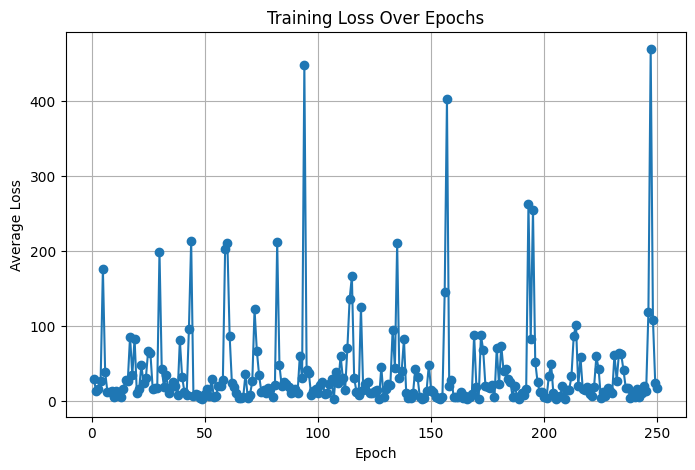

In [ ]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

# Model and optimizer
model_tf = RelationExtractionHead(hidden_size=hidden_size, num_relations=num_relations)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_history = []

for epoch in range(num_epochs):
    samples_this_epoch = random.randint(sample_range_min, sample_range_max)
    total_batches = int(np.ceil(samples_this_epoch / batch_size))

    epoch_dataset = (
        train_dataset.unbatch()
        .shuffle(buffer_size=10000, reshuffle_each_iteration=True)
        .take(samples_this_epoch)
        .batch(batch_size)
    )

    print(f"Epoch {epoch+1}/{num_epochs}, sampling {samples_this_epoch} examples...")
    epoch_loss = []

    for batch, (h_i_batch, h_j_batch, labels_batch, keys_batch) in enumerate(tqdm(epoch_dataset, total=total_batches, desc=f"Epoch {epoch+1}", unit="batch")):
        if len(h_i_batch.shape) == 3:
            h_i_batch = tf.reduce_mean(h_i_batch, axis=1)
            h_j_batch = tf.reduce_mean(h_j_batch, axis=1)

        with tf.GradientTape() as tape:
            logits = model_tf((h_i_batch, h_j_batch), training=True)
            loss = loss_fn(labels_batch, logits)

        grads = tape.gradient(loss, model_tf.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_tf.trainable_variables))
        epoch_loss.append(loss.numpy())

    avg_loss = np.mean(epoch_loss)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

## Evaluation
Run model evaluation on the test dataset, computing predictions, probabilities, and performance metrics.

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np
from tqdm import tqdm
import tensorflow as tf

class RelationModelTesterTF:
    def __init__(self, model, dataset, batch_size=32, num_samples=None):
        self.model = model
        self.dataset = dataset
        self.batch_size = batch_size
        # estimate num_samples if not provided
        self.num_samples = num_samples or sum(1 for _ in dataset)
        self.total_batches = int(np.ceil(self.num_samples / batch_size))

    def evaluate(self):
        all_preds, all_labels = [], []
        all_probs, all_keys = [], []
        all_h_i, all_h_j = [], []

        bar = tqdm(self.dataset, desc="Evaluating", total=self.total_batches, unit="batch")
        for h_i, h_j, labels, keys in bar:
            # pool sequences if 3D
            if len(h_i.shape) == 3:
                h_i = tf.reduce_mean(h_i, axis=1)
                h_j = tf.reduce_mean(h_j, axis=1)

            logits = self.model((h_i, h_j), training=False)
            probs  = tf.nn.softmax(logits, axis=-1)
            preds  = tf.argmax(probs, axis=-1)

            all_preds.extend(preds.numpy().tolist())
            all_labels.extend(labels.numpy().tolist())
            all_probs.extend(probs.numpy().tolist())
            all_keys.extend([k.numpy() for k in keys])
            all_h_i.extend(h_i.numpy().tolist())
            all_h_j.extend(h_j.numpy().tolist())

        # Overall accuracy
        accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

        # Weighted precision, recall, F1 with zero_division guard
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds,
            average="weighted",
            zero_division=0
        )

        # Full classification report (string)
        report_str = classification_report(
            all_labels, all_preds,
            zero_division=0
        )

        return {
            "predictions": all_preds,
            "ground_truth": all_labels,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "classification_report": report_str,
            "probabilities": all_probs,
            "keys": all_keys,
            "h_i": all_h_i,
            "h_j": all_h_j,
        }



In [ ]:
# Run evaluation
tester = RelationModelTesterTF(
    model_tf,
    test_dataset,
    batch_size=32,
    num_samples=len(test_dataset_hf)
)
results = tester.evaluate()

# Print overall metrics
print(f"Test Accuracy          : {results['accuracy']:.2%}")
print(f"Weighted Precision     : {results['precision']:.4f}")
print(f"Weighted Recall        : {results['recall']:.4f}")
print(f"Weighted F1-score      : {results['f1']:.4f}")
print(f"Classification Report  :")
print(results["classification_report"])

# Detailed sample-wise breakdown
print("Sample-wise Predictions:")
for i in range(min(10, len(results["predictions"]))):
    print(f"Sample {i}")
    print("  True Label      :", results["ground_truth"][i])
    print("  Predicted Label :", results["predictions"][i])
    print("  Probabilities   :", np.round(results["probabilities"][i], 4))
    print("  h_i (first 5)   :", np.round(results["h_i"][i][:5], 4))
    print("  h_j (first 5)   :", np.round(results["h_j"][i][:5], 4))


Evaluating: 100%|██████████| 4484/4484 [04:28<00:00, 16.69batch/s]


Test Accuracy          : 99.55%
Weighted Precision     : 0.9955
Weighted Recall        : 0.9955
Weighted F1-score      : 0.9955
Classification Report  :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     72037
           1       0.99      1.00      1.00     71439

    accuracy                           1.00    143476
   macro avg       1.00      1.00      1.00    143476
weighted avg       1.00      1.00      1.00    143476

Sample-wise Predictions:
Sample 0
  True Label      : 1
  Predicted Label : 1
  Probabilities   : [0. 1. 0. 0. 0.]
  h_i (first 5)   : [-0.4089  0.6391 -0.5235  0.1602  2.6866]
  h_j (first 5)   : [-0.2625  0.0259 -0.0436 -0.4732  0.153 ]
Sample 1
  True Label      : 1
  Predicted Label : 1
  Probabilities   : [0. 1. 0. 0. 0.]
  h_i (first 5)   : [ 0.1426  0.3798 -0.0402  0.5913  1.2908]
  h_j (first 5)   : [-0.1201  0.1056 -0.3505  0.5686  1.3624]
Sample 2
  True Label      : 1
  Predicted Label : 1
  Probabilitie

In [ ]:
import os
import json
# Save model artifacts
SAVE_DIR = os.path.join(drive_mount_path, 'MyDrive/layoutlmv3_relation_model_tf')
os.makedirs(SAVE_DIR, exist_ok=True)


# Save weights-only checkpoint (HDF5 format)
weights_path = os.path.join(SAVE_DIR, 'relation_head_weights.weights.h5')
model_tf.save_weights(weights_path)
print(f"✔ Weights-only HDF5 checkpoint written to: {weights_path}")
tf.saved_model.save(model_tf, os.path.join(SAVE_DIR, 'saved_model'))

# Save the data to json file
with open(os.path.join(SAVE_DIR, 'relation_config.json'), 'w') as f:
    json.dump({
        'hidden_size': hidden_size,
        'num_relations': num_relations
    }, f)
print(f"✔ Saved model artifacts to {SAVE_DIR}")

✔ Weights-only HDF5 checkpoint written to: /content/drive/MyDrive/layoutlmv3_relation_model_tf/relation_head_weights.weights.h5
✔ Saved model artifacts to /content/drive/MyDrive/layoutlmv3_relation_model_tf
